# MOVIE RATING ANALYSIS
This is just a basic (but decently comprehensive) data exploration exercise, trying to cover as much Pandas DataFrames and Matplotlib crunching as possible, all for my own learning process.

My first contact with this dataset is from an online course in EDX (UCSanDiegoX: DSE200x Python for Data Science), and comes to show how many questions and insights can be derived from very basic information (and I've only used 2 of the 4 data files available).  

Along the way I discovered another important learning objective, as my laptop (8Gb RAM) was not able to properly handle the 20MM rows of the ratings data when combined with the movies data (expanding the number of columns significanty), so I had to apply even more Pandas tricks to filter and combine the two data files on the fly, and also continually doing some housekeeping on the active namespace deleting unnecesary variables when they were no longer required.  

I'd appreciate any comments, not on the data exploration itself which i, but mainly on how to perform some of the calculations over dataframes in more efficient ways.


## Import the required modules

In [2]:
%%time
from timeit import default_timer
start = default_timer()
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Wall time: 11.7 s


## Load required files
For first time data load:
1. Load original CSV files.
2. Sort by movieId (main key we'll be using) and reset the indices.
3. Split title and year into separate columns. Convert year to datetime.
4. Categorize genres properly: split strings into boolean columns per genre.
5. Modify the rating timestamp: from universal seconds to datetime year.
6. Check for NaN values. Clean (delete rows) if % of NaN values is small.

In [3]:
%%time
st = default_timer()
os.chdir(r"E:\2021s\Data mining\project_dataset\ml-latest\ml-latest")

# First time data load.
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
    
# Organise a bit and store into feather-format
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
#ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)
    
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
Number of movies Null values:  327
Number of ratings Null values:  0
Elapsed time(sec):  49.04
Wall time: 49 s


In [4]:
movies.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995.0,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


## Explore the data with some basic plots  <br>

<font color=darkblue>**PLOT#1**: Number of movies and ratings per year. <br/font>
    
<font color=green>**INSIGHT#1**: Number of movies released per year increasing almost exponentially until 2004, then flattening and dropping signifincantly in 2015 (2020 data is incomplete). Does this confirm expontential growth (i.e. bubbles) is seldom sustainable in the long term? No ratings before 1995, likely to do with the availability of Internet to general public.</font>

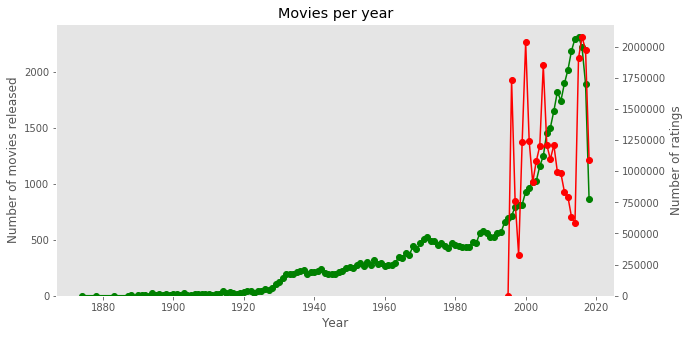

Elapsed time(sec):  2.88


In [5]:
st = default_timer()

# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#2**: Cumulative number of movies, in total and per genre. <br/font>
<font color=green>**INSIGHT#2**: On average, movies are categorized into 2 genres (i.e. number of movies-genres 54k doubles the number of movies 27k). Comedy 8.3k and Drama 13.3k are the top genres used.</font>

<Figure size 720x360 with 0 Axes>

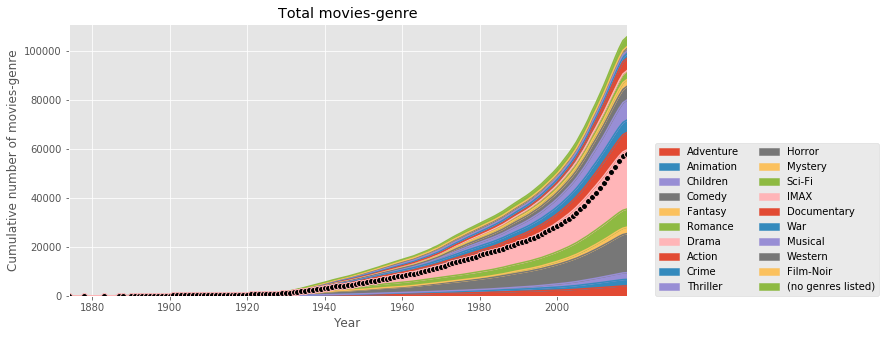

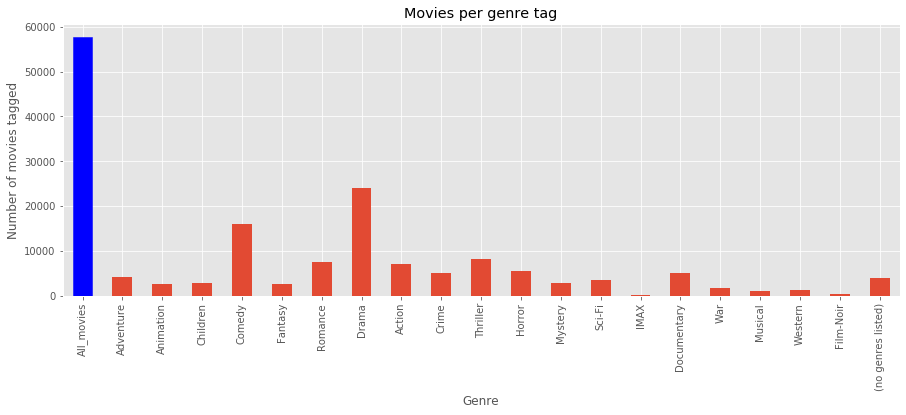

Elapsed time(sec):  1.62


In [6]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#3**: Distributions by genre, on top of total rating distribution. This will help identifying consitent ratings or outliers (e.g. Comedies being rated higher in general). <br/font>
<font color=green>**INSIGHT#3**: All genres show a similar pattern (right-skewed log-normal distribution??), except perhaps Horror movies which are a bit skewed to the left (poorer ratings)...people don't like being scared, no matter how good the movie is fro a technical point of view? Movies without a tagged genre (no-genres listed) are also outliers, but likely due to the low number of ocurrences.</font>

C:\Users\thinkpad\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\hist.py:412: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


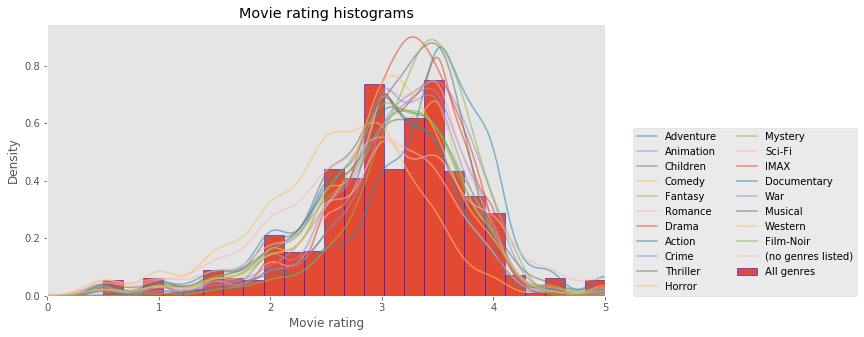

Elapsed time(sec):  134.06


In [7]:
st = default_timer()

dftmp = ratings[['movieId','rating']].groupby('movieId').mean()

# Initialize empty list to capture basic stats by gere
rating_stats = []
# Plot general histogram of all ratings
dftmp.hist(bins=25, grid=False, edgecolor='b', normed=True, label ='All genres', figsize=(10,5))
# Plot histograms (kde lines for better visibility) per genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]==True]
    dftmp = ratings[ratings.set_index('movieId').index.isin(dftmp.set_index('movieId').index)]
    dftmp = dftmp[['movieId','rating']].groupby('movieId').mean()
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    avg = dftmp.rating.mean()
    std = dftmp.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

# Housekeeping
%reset_selective -f (^avg$|^dftmp$|^genre$|^std$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#4**: Compute basic statistics (avg, std) per genre. Plot dispersion (box plot). <br>
<font color=green>**INSIGHT#4**: As highlighted in the prevous plot, all genres really show similar behaviour. Using numbers in this case, mean rating is sligtly above 3, with a standard deviation around 0.65.</font>

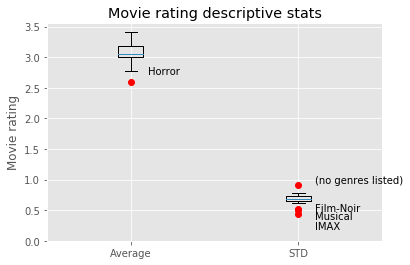

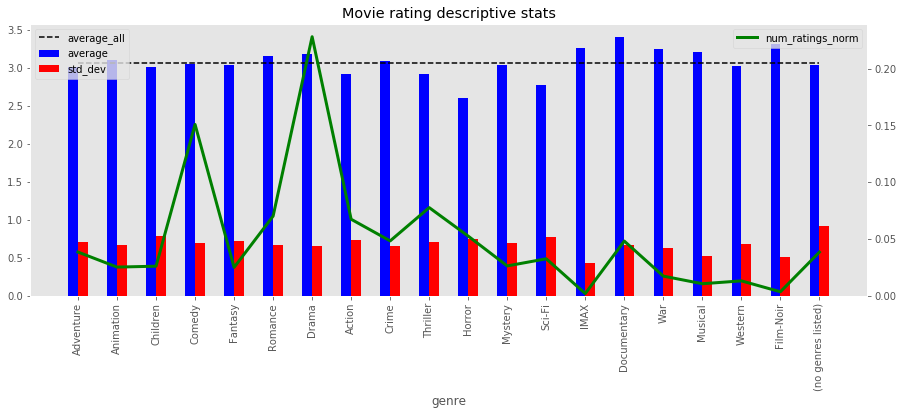

Outliers:  {'IMAX', 'Film-Noir', 'Horror', 'Musical', '(no genres listed)'}
genre             Adventure  Animation  Children    Comedy   Fantasy  \
average            3.006225   3.098054  3.006414  3.051934  3.037675   
std_dev            0.699975   0.670286  0.780743  0.695415  0.724496   
num_ratings_norm   0.038388   0.025172  0.025958  0.150770  0.024898   
average_all        3.065947   3.065947  3.065947  3.065947  3.065947   

genre              Romance     Drama    Action     Crime  Thriller    Horror  \
average           3.152193  3.184050  2.910299  3.084302  2.912963  2.594532   
std_dev           0.661035  0.648494  0.728290  0.647412  0.707828  0.739542   
num_ratings_norm  0.070068  0.228027  0.067297  0.048235  0.077561  0.052435   
average_all       3.065947  3.065947  3.065947  3.065947  3.065947  3.065947   

genre              Mystery    Sci-Fi      IMAX  Documentary       War  \
average           3.039859  2.769736  3.259231     3.404474  3.238589   
std_dev         

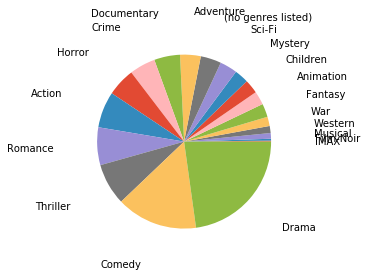

Elapsed time(sec):  1.66


In [8]:
st = default_timer()

# Construct a DataFrame with all the basic stats per genre
rating_sum = pd.DataFrame(rating_stats,  columns=['genre', 'average', 'std_dev'])
rating_sum.set_index('genre', inplace=True)
# Display a boxplot to show the dispersion of average and standard deviation
bxplot = plt.boxplot(rating_sum.T, labels=['Average', 'STD'], sym="ro")
# Properly label the outliers
outliers = []
for i, value in enumerate(bxplot['fliers']):
    for val in value.get_ydata():
        bxplot_label = rating_sum.index[rating_sum.iloc[:, i] == val][0]
        outliers.append(bxplot_label)
        plt.annotate(bxplot_label, xy=(i+1.1, val+np.random.uniform(-0.25,0.25))) # Trick to prevent overlapping
outliers = set(outliers)
plt.ylim(0,)
plt.ylabel('Movie rating')
plt.title('Movie rating descriptive stats')
plt.show()

# Bar chart with average rating, standard deviation and normalized number of ratings per genre
# Calculate the normalized number of ratings per genre
rating_sum['num_ratings_norm']=df.iloc[-1, 1:]/df.iloc[-1, 1:].sum()
# Calculate the average rating for all genres
rating_sum['average_all']=rating_sum.average.mean()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

rating_sum[['average', 'std_dev']].plot(kind='bar', color=['b','r'], ax=ax, position=0.5, grid=False)
rating_sum['average_all'].plot(kind='line',style='--', color=['black'], ax=ax, grid=False)
rating_sum['num_ratings_norm'].plot(kind='line', color='g', ax=ax2, grid=False, linewidth=3)

ax.legend(loc=2)
ax2.legend(loc=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Movie rating descriptive stats')
plt.autoscale()
ax2.set_ylim(0,)
plt.show()

print("Outliers: ", outliers)
print(rating_sum.T)

# Quick pie chart to visualize how 3 genres take almost 50% of ratings
rating_sum.sort_values(by='num_ratings_norm', inplace=True)
plt.pie(rating_sum['num_ratings_norm'], labels=rating_sum.T.columns, labeldistance=1.5)
plt.show()


# Housekeeping
%reset_selective -f (^avg$|ax|bxplot|^df$|^dftmp$|^i$|^rating_stats$|^rating_sum$|^val$|^value$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#5**: Average rating for all individual movies. <br>
<font color=green>**INSIGHT#5**: Especially after 1970, it seems there are more lower ratings, but also more higher (4.5-5.0)...it could just an effect of having more movies. Not many insights from this plot.</font>

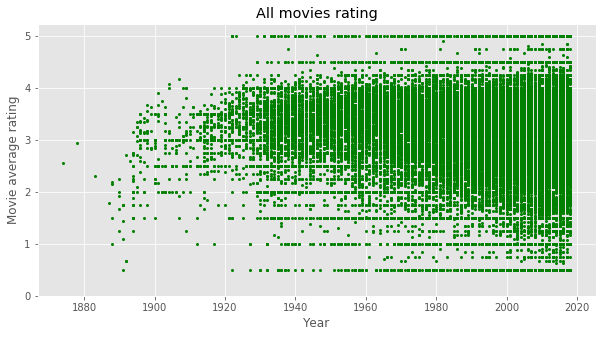

Elapsed time(sec):  3.21


In [9]:
st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#6**: Average rating for all movies in each year, and also per genre. <br>
<font color=green>**INSIGHT#6**: Slight decline in average movie ratings after 1960, but still remains above 3. Range quite narrow, except for a few outliers.</font>

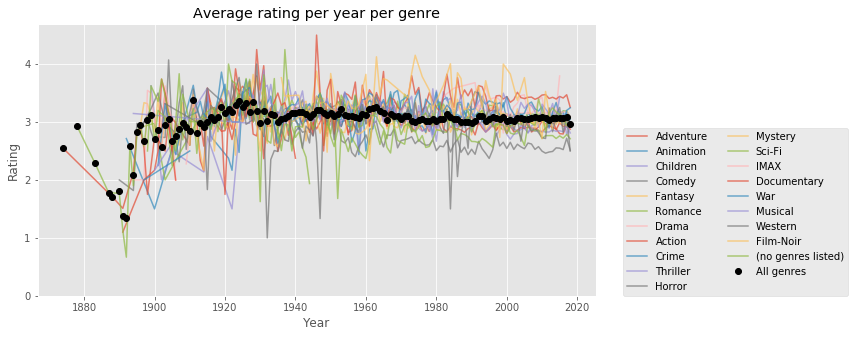

Elapsed time(sec):  115.49


In [10]:
st = default_timer()

plt.figure(figsize=(10,5))
# For each genre
for genre in genres_unique.genre:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')

plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year per genre')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#7**: Same as #6, but only the outliers now. <br>
<font color=green>**INSIGHT#7**: All the outliers present vary few occurrences: IMAX 196, Film-Noir 330, no-genre 237. In any case, Film-Noir movies are generally rated well above average, and the ones without any classification tend to do very poorly...perhaps having no genre to anchor or relate to impairs critics?.</font>

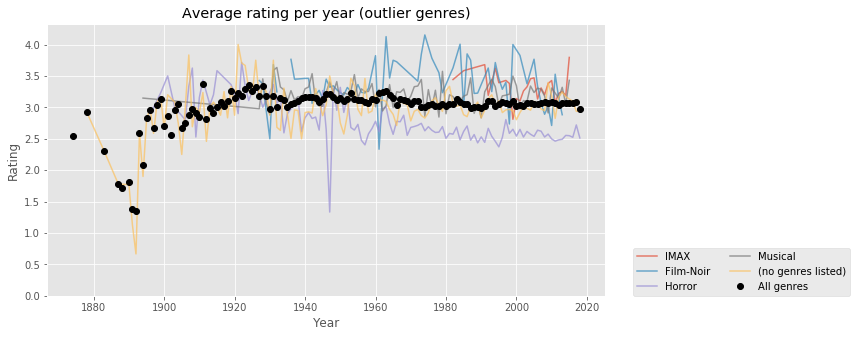

Elapsed time(sec):  32.4


In [11]:
st = default_timer()

plt.figure(figsize=(10,5))
for genre in outliers:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')
    
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year (outlier genres)')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$|^outliers$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#8**: Average ratings per user. <br>
<font color=green>**INSIGHT#8**: Users have a positive bias in general, with roughly 95% of their average ratings above the mid-point of 2.5. This is to be expected, and could have many explanations: users actually watch the better movies due to available ratings (and this should get better over time, as the rating system expands); users don't bother that much to rate bad movies as they do with the good ones (i.e. we don't want other to know we watched such a piece of s***), etc.</font>

C:\Users\thinkpad\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)
C:\Users\thinkpad\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


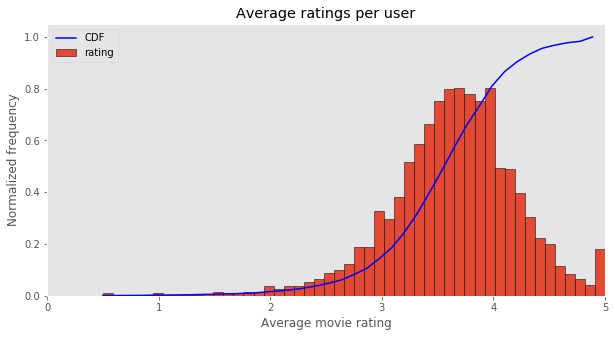

Elapsed time(sec):  8.9


In [12]:
st = default_timer()

dftmp = ratings[['userId','rating']].groupby('userId').mean()
# Plot histogram
dftmp.plot(kind='hist', bins=50, grid=0, normed=True, edgecolor='black', figsize=(10,5))
# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, normed=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^base$|^cumulative$|^values$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#9**: Rating timestamp vs. movie year vs. rating count<br>
<font color=green>**INSIGHT#9**: Besides the evident insight that newer movies get more ratings, and that older movies get a number of ratings inversely proportional to their age, we can also see than the oldest movies have just received ratings very recently (2010+), implying those were not readily for users to watch available before. There's also sort of a "block behaviour", where at any point in time, movies with X number of ratings stop some Y years before (e.g. in 2005, there are no movies older than 1980 with +10000 ratings).</font>

C:\Users\thinkpad\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


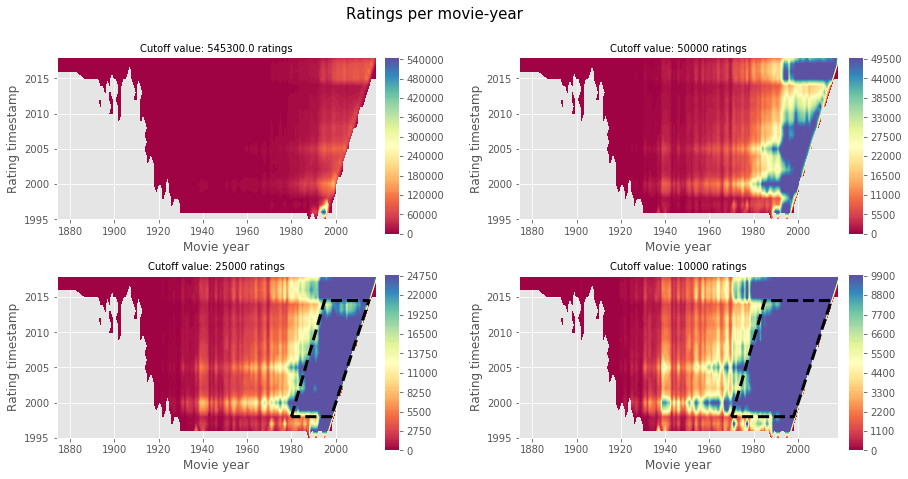

Elapsed time(sec):  15.64


In [13]:
st = default_timer()
# Combine movies year with ratings timestamps
dftmp = movies[['movieId', 'year']].merge(ratings[['movieId', 'timestamp']], on='movieId')
dftmp = dftmp.groupby(['year', 'timestamp']).count().reset_index()
dftmp.columns=['year', 'timestamp', 'count']
dftmp = dftmp.pivot('year', 'timestamp')

# Plot using a contour (color reflects number of ratings for each year-timestamp pair).
# Could also use heatmap or imshow...
X=dftmp.columns.levels[1].values
Y=dftmp.index.values
Z=dftmp.values
Xi,Yi = np.meshgrid(X, Y)

fig, axs = plt.subplots(2,2)
fig.set_size_inches(14,7)
cutoff = [np.nanmax(Z), 50000, 25000, 10000] # Modify the contour plots a different max values.
Zcap = np.copy(Z)
locx = [0.45, 0.91, 0.45, 0.91] # x location for the individual colorbars
locy = [0.53, 0.53, 0.1, 0.1] # y location for the individual colorbar
for i, ax in enumerate(axs.flatten()):
    Zcap[Zcap>cutoff[i]]=cutoff[i]
    cmvals = ax.contourf(Yi, Xi, Zcap, 100, cmap=plt.cm.Spectral)
    ax.set_xlabel('Movie year')
    ax.set_ylabel('Rating timestamp')
    ax.set_title('Cutoff value: %s ratings' %cutoff[i], fontsize=10)
    cax = fig.add_axes([locx[i], locy[i], 0.015, 0.35])
    fig.colorbar(cmvals, cax=cax, orientation='vertical')
fig.suptitle('Ratings per movie-year', fontsize=15)
plt.subplots_adjust(hspace=0.35,wspace=0.45)

# Highlight key regions in the plots, just roughly...
axs.flatten()[2].plot([1980, 1995, 2015, 1998, 1980], [1998, 2014.5, 2014.5, 1998, 1998], 
                      '--', color='black',linewidth=3)
axs.flatten()[3].plot([1970, 1985, 2015, 1998, 1970], [1998, 2014.5, 2014.5, 1998, 1998], 
                      '--', color='black',linewidth=3)
plt.show()

# Housekeeping
%reset_selective -f (^ax$|^axs$|^cmvals$|^cutoff$|^dftmp$|^i$|loc|X|Y|Z)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#10**: Rating timestamp vs. movie year vs. average rating<br>
<font color=green>**INSIGHT#10**: After 1980, average rating declines clearly; a lower ratings count for sure has an impact, but it seems -perceived- movies quality did step-decline at that point. Also, movies released 1930-1980 and rated 1996-2003 seem to comform the better rated block.</font>

C:\Users\thinkpad\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


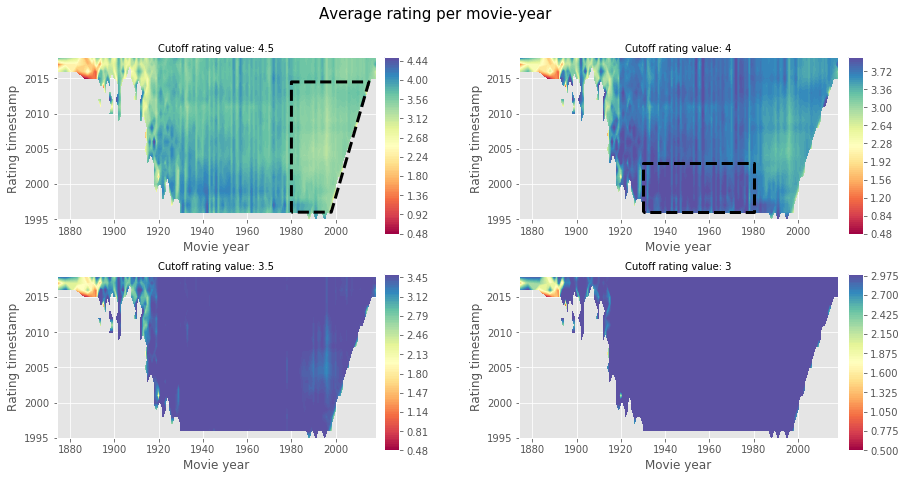

Elapsed time(sec):  18.81


In [14]:
st = default_timer()
# Combine movies year with ratings timestamps
dftmp = movies[['movieId', 'year']].merge(ratings[['movieId', 'timestamp', 'rating']], on='movieId')
dftmp.drop('movieId', axis=1, inplace=True)
dftmp = dftmp.groupby(['year', 'timestamp']).mean().reset_index().pivot('year', 'timestamp')

# Plot using a contour (color reflects number of ratings for each year-timestamp pair).
# Could also use heatmap or imshow...
X=dftmp.columns.levels[1].values
Y=dftmp.index.values
Z=dftmp.values
Xi,Yi = np.meshgrid(X, Y)

fig, axs = plt.subplots(2,2)
fig.set_size_inches(14,7)
cutoff = [4.5, 4, 3.5, 3] # Modify the contour plots a different max values.
Zcap = np.copy(Z)
locx = [0.45, 0.91, 0.45, 0.91] # x location for the individual colorbars
locy = [0.53, 0.53, 0.1, 0.1] # y location for the individual colorbar
for i, ax in enumerate(axs.flatten()):
    Zcap[Zcap>cutoff[i]]=cutoff[i]
    cmvals = ax.contourf(Yi, Xi, Zcap, 100, cmap=plt.cm.Spectral)
    ax.set_xlabel('Movie year')
    ax.set_ylabel('Rating timestamp')
    ax.set_title('Cutoff rating value: %s' %cutoff[i], fontsize=10)
    cax = fig.add_axes([locx[i], locy[i], 0.015, 0.35])
    fig.colorbar(cmvals, cax=cax, orientation='vertical')
fig.suptitle('Average rating per movie-year', fontsize=15)
plt.subplots_adjust(hspace=0.35,wspace=0.45)

# Highlight key regions in the plots, just roughly...
axs.flatten()[0].plot([1980, 1980, 2015, 1998, 1980], [1996, 2014.5, 2014.5, 1996, 1996], 
                      '--', color='black', linewidth=3)
axs.flatten()[1].plot([1930, 1930, 1980, 1980, 1930], [1996, 2003, 2003, 1996, 1996], 
                      '--', color='black', linewidth=3)
plt.show()

# Housekeeping
%reset_selective -f (^ax$|^axs$|^cax$|^cmvals$|^cutoff$|^dftmp$|^fig$|^i$|loc|X|Y|Z)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#11**: Ratings per user.<br>
<font color=green>**INSIGHT#11**: As expected, exponentially declining function, with no users with less than 20 ratings give, and some outliers with 7.5k and 9.2k ratings...that's insane, 9,200 movies watched and rated, at 2 hours each, more than two years 100% dedicated to watching movies!!!.</font>

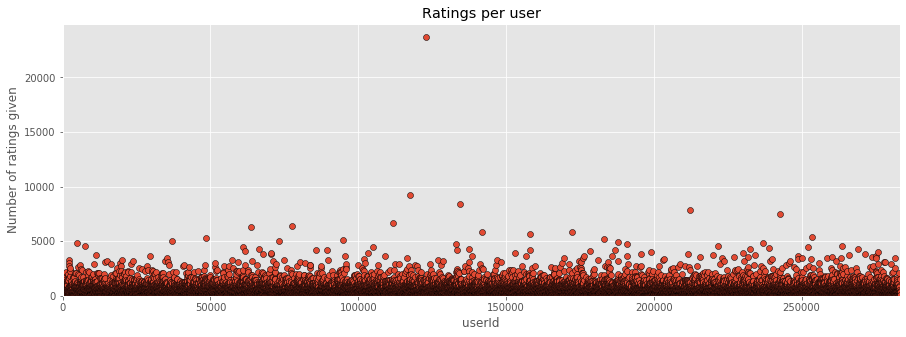

23715


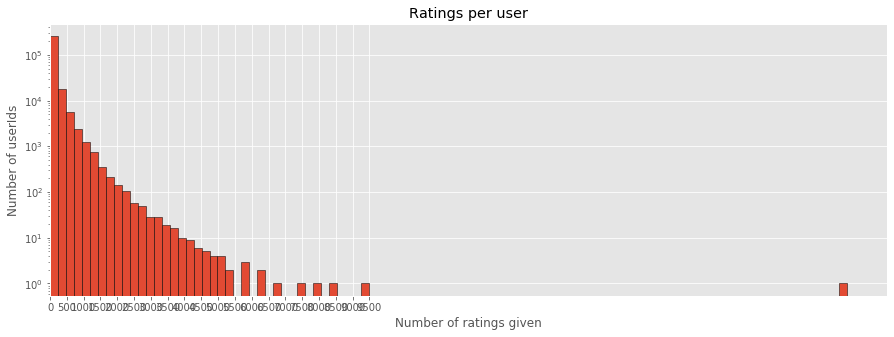

Elapsed time(sec):  9.98


In [15]:
st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,len(dftmp.index))
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of userIds')
plt.xlim(0,)
print(max(dftmp.num_ratings))
plt.xticks(np.arange(0,10000,500))
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [16]:
ratings.shape

(27753444, 4)

<font color=darkblue>**PLOT#12**: Ratings per movie.<br>
<font color=green>**INSIGHT#12**: My favorite movie (no kidding) is the "best-rated & most-popular" movie ever!!! But I'm so pissed of Gladiator didn't make it anywhere close to the top....</font>

In [17]:
ratings.head(20)

,userId,movieId,rating,timestamp
0,220887,1,4.5,2004
1,135139,1,3.0,1997
2,107968,1,3.0,2005
3,235760,1,3.5,2006
4,30273,1,5.0,2001
5,78901,1,1.0,2015
6,9462,1,4.0,2005
7,78903,1,3.5,2017
8,57009,1,4.0,1996
9,160971,1,5.0,1997


In [ ]:
st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()

# Let's check those movies with +40k reviews, those should be pretty popular movies!
print(movies.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]]['title'])
# Let's check the average rating too, those should be pretty good movies!
ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean().rating.plot(style='o')
plt.ylabel('Average rating')
plt.title('Most popular movies rating')
plt.show()

# Which is the best most popular movie ever??
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean()
best = movies.set_index('movieId').loc[tmp.rating.idxmax].title
print ('Best most popular movie ever is...%s' %best)

# Housekeeping
%reset_selective -f (^dftmp$|^tmp$|^best$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

### Compute total runtime

In [ ]:
runtime = default_timer() - start
print ("Elapsed time(sec): ", round(runtime,2))

# Housekeeping
%reset_selective -f (^runtime$|^st$|^start$)

In [ ]:
%whos

# Questions still to be answered
Still had plenty of interesting questions to be answered with this simple dataset, but I believe I have already achieved my learnign objective at this stage...and also wanted to publish my first Kaggle thing ;)


1.Check how users change their ratings over time. Do they become complacent or demanding?  
2.Check how users rate different genres. Do they like some more than others in general?  
3.Do users watch all genres equally or do they specialize?  
4.Do we need all 20MM ratings? Could we achieve same results with just 50K properly sampled, for example?  
5.What are the most common genres combinations? Do they all make sense (i.e. "Comedy and Drama")?  
6.Is there any correlation between genres and ratings? Is it a guarantee of success to do certain types of movies?
7.Which users are the most realiable (more similar to the mean) for any movie and for individual genres?  

Etc, etc...

In [19]:
ratings.head()

,userId,movieId,rating,timestamp
0,220887,1,4.5,2004
1,135139,1,3.0,1997
2,107968,1,3.0,2005
3,235760,1,3.5,2006
4,30273,1,5.0,2001


In [20]:
rearrange_score = pd.DataFrame(columns = ['movieId', 'score'])

In [21]:
import sklearn as sk

(array([ 442388.,  886233.,  441354., 1850627., 1373419., 5515668.,
        3404360., 7394710., 2373550., 4071135.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

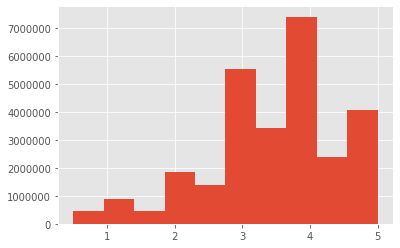

In [22]:
plt.hist(ratings['rating'])

In [31]:
ave_rating = ratings['rating']/(ratings.shape[0] * ratings['rating'].mean())

In [34]:
ave_rating.sum()

0.9999999999999997

In [36]:
ratings['rating'].value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

In [37]:
type(ratings['rating'].value_counts())

pandas.core.series.Series

In [39]:
ratings['rating'].value_counts().index

Float64Index([4.0, 3.0, 5.0, 3.5, 4.5, 2.0, 2.5, 1.0, 0.5, 1.5], dtype='float64')

In [41]:
dict_rating = {'score':ratings['rating'].value_counts().index, 'frequency': ratings['rating'].value_counts().values/ratings.shape[0]}

In [42]:
rating_frequency = pd.DataFrame(dict_rating)

In [43]:
rating_frequency

,score,frequency
0,4.0,0.266443
1,3.0,0.198738
2,5.0,0.146689
3,3.5,0.122664
4,4.5,0.085523
5,2.0,0.066681
6,2.5,0.049486
7,1.0,0.031932
8,0.5,0.015940
9,1.5,0.015903


In [44]:
rating_frequency.sort_values('score')

,score,frequency
8,0.5,0.015940
7,1.0,0.031932
9,1.5,0.015903
5,2.0,0.066681
6,2.5,0.049486
1,3.0,0.198738
3,3.5,0.122664
0,4.0,0.266443
4,4.5,0.085523
2,5.0,0.146689
